In [1]:
import datetime
import math
import time
import itertools
from contextlib import closing
from collections import OrderedDict
import json
import numpy as np
import pandas as pd
import MySQLdb
import pymssql
from sqlalchemy import create_engine
import dfutils
import matplotlib.pyplot as plt

In [2]:
#DB_NAME = 'wic'
#WIC_DB_HOST = 'wic-risk-database.cwi02trt7ww1.us-east-1.rds.amazonaws.com'
#DB_USER = 'aduprey'
#DB_PASSWORD = 'aduprey'
WIC_DB_HOST = 'wic-risk-database.cwi02trt7ww1.us-east-1.rds.amazonaws.com'
DB_USER = 'root'
DB_PASSWORD = 'waterislandcapital'
DB_NAME = 'wic'
engine = create_engine("mysql://" + DB_USER + ":" + DB_PASSWORD + "@" + WIC_DB_HOST + "/wic")

In [3]:
def wic_optimized_execute(query, commit=False, retrieve_column_names=False, connection_timeout=250, extra_values=None):
    with closing(MySQLdb.connect(host=WIC_DB_HOST, user=DB_USER, passwd=DB_PASSWORD, db=DB_NAME)) as wic_cnx:
        with closing(wic_cnx.cursor()) as wic_cursor:

            if extra_values is not None:
                wic_cursor.execute(query, (extra_values,))
            else:
                wic_cursor.execute(query)
            if commit:
                wic_cnx.commit()
                return
            fetched_res = wic_cursor.fetchall()  # fetch (and discard) remaining rows

            if retrieve_column_names:
                return fetched_res, [i[0] for i in wic_cursor.description]

            return fetched_res

In [4]:
def optimized_execute(query, commit=False):
    '''
    Executes the search query in Northpoint
    '''
    
    with closing(pymssql.connect(host='10.16.1.16', user='readonly_user', password='readonly_user',
                                 database='PnLAppDb')) as np_pnl_conn:
        with closing(np_pnl_conn.cursor()) as np_pnl_cursor:
            np_pnl_cursor.execute(query)
            if commit:
                np_pnl_conn.commit()
                return

            fetched_res = np_pnl_cursor.fetchall()  # fetch (and discard) remaining rows\
            return fetched_res

In [5]:
def get_sleeves_pnl_cache():
    # region query
    query = "SELECT Date, FundCode, Sleeve, `P&L($)` " \
            "FROM " + DB_NAME + ".sleeve_pnl_cache"
    # endregion
    res = wic_optimized_execute(query)
    cols = ['Date', 'Fund', 'Sleeve', 'Total P&L']
    df = pd.DataFrame(list(res), columns=cols)
    df['Date'] = df['Date'].apply(lambda x: pd.to_datetime(x))
    return df

In [6]:
def get_sleeves_capital_cache():
    # region query
    query = "SELECT Date, FundCode, Sleeve, GrossMktVal " \
            "FROM " + DB_NAME + ".sleeve_capital_cache"
    # endregion
    res = wic_optimized_execute(query)
    cols = ['Date', 'Fund', 'Sleeve', 'GrossMktVal']
    df = pd.DataFrame(list(res), columns=cols)
    df['Date'] = df['Date'].apply(lambda x: pd.to_datetime(x))
    return df


In [7]:
def get_NAV_df_by_date(fund_name = None, start_date_yyyy_mm_dd=None):
    if start_date_yyyy_mm_dd is None:
        start_date_yyyy_mm_dd = '20150101'
    elif (start_date_yyyy_mm_dd is not None) & (type(start_date_yyyy_mm_dd) != str):
        start_date_yyyy_mm_dd = start_date_yyyy_mm_dd.strftime('%Y%m%d')

    query = "SELECT A.[DATE], A.NAV, " \
            "CASE B.FundName " \
            "WHEN 'Columbia' THEN 'CAM' " \
            "WHEN 'Litman Gregory' THEN 'LG' " \
            "WHEN 'The Arbitrage Credit Opportunities Fund' THEN 'TACO' " \
            "WHEN 'The Arbitrage Event-Driven Fund' THEN 'AED' " \
            "WHEN 'The Arbitrage Fund' THEN 'ARB' " \
            "WHEN 'TransAmerica' THEN 'TAF' " \
            "WHEN 'WIC Arbitrage Partners' THEN 'WIC' " \
            "WHEN 'The Arbitrage Tactical Equity Fund' THEN 'TAQ' " \
            "WHEN 'Water Island Event-Driven Fund' THEN 'WED' " \
            "WHEN 'Water Island Capital Lev Arb Fund' THEN 'LEV' " \
            "WHEN 'WATER ISLAND MERGER ARBITRAGE INSTITUTIONAL' THEN 'MACO' " \
            "WHEN 'Morningstar Alternatives Fund' THEN 'MALT' " \
            "END AS FundCode " \
            "FROM PnLAppDb.pnl.DailyNAV AS A " \
            "INNER JOIN PnLAppDb.dbo.Funds AS B ON A.FundId = B.FundID "
 
    if fund_name is not None and start_date_yyyy_mm_dd is not None:
        query += "WHERE  A.[Date] > '" + start_date_yyyy_mm_dd + "' AND B.FundName = '" + fund_name + "' "
    elif fund_name is not None:
        query += " WHERE B.FundName = '" + fund_name + "' "
    elif start_date_yyyy_mm_dd is not None:
        query += "WHERE  A.[Date] > '" + start_date_yyyy_mm_dd + "' "

    results = optimized_execute(query)
    df = pd.DataFrame(results, columns=["Date", "NAV", "FundCode"])
    df.set_index(pd.DatetimeIndex(df['Date']), inplace=True)
    df.index.name = 'Date'
    df = df.sort_index()
    df['NAV'] = df['NAV'].astype(float)
    #idx = pd.date_range(df['Date'].min(), df['Date'].max())
    #df = df.reindex(idx, fill_value=np.nan)
    del df['Date']
    df.reset_index(level=0, inplace=True)
    df.rename(columns={"index": "Date"}, inplace=True)
    df.index.name = 'Date'
    df.ffill(inplace=True)
    df.set_index(pd.DatetimeIndex(df['Date']), inplace=True)
    df['Date'] = df['Date'].apply(lambda x: pd.to_datetime(x))
    # df.reset_index(inplace=True)
    df = df.reset_index(level=0, drop=True).reset_index()  # Added by Kshitij
    del df['index']
    return df[df['Date'] <= (datetime.datetime.today() - datetime.timedelta(days=1))]

In [17]:
def calculate_sleeve_drawdown():
    today = datetime.datetime.today().strftime('%Y-%m-%d')
    
    #Collects all the data to perform the calcs
    sleeve_pnl = get_sleeves_pnl_cache() #Get the Daily PnL for the sleeves of each fund
    fund_nav_df = get_NAV_df_by_date() #Fund NAV
    sleeve_bet_capital = get_sleeves_capital_cache() #Get the GrossMktVal for the sleeves of each fund

    #Takes the daily tradegroup dollar P&L and converts it to bps and then calculates the cumulative sum -- NAV
    funds = ['ARB', 'AED', 'CAM', 'TACO', 'TAQ', 'LEV', 'LG', 'MACO', 'MALT', 'WED']
    sleeves = sleeve_pnl['Sleeve'].unique()
    
    sleeve_drawdown_df = pd.DataFrame()
    for fund_code in funds:
        #sleeves = ['Merger Arbitrage', 'Equity Special Situations', 'Credit Opportunities',
                   #'Opportunistic', 'Forwards','Break']
        fund_nav = fund_nav_df[fund_nav_df.FundCode == fund_code].copy()
        for slv in sleeves:
            sleeve_pnl_df = sleeve_pnl[(sleeve_pnl['Fund'] == fund_code) & (sleeve_pnl['Sleeve'] == slv)][['Date', 'Total P&L']].sort_values(by='Date').copy()
            if len(sleeve_pnl_df) == 0:
                continue
            sleeve_capital_df = sleeve_bet_capital[(sleeve_bet_capital['Fund'] == fund_code) & (sleeve_bet_capital['Sleeve'] == slv)][['Date', 'GrossMktVal']].sort_values(by='Date').copy()
            pnl_df = pd.merge(sleeve_pnl_df, fund_nav[['Date', 'NAV']], how='inner', on=['Date'])
            pnl_df['Shifted_Capital_NAV'] = pnl_df['NAV'].shift(1)
            if pd.isnull(pnl_df['Shifted_Capital_NAV'].iloc[0]):
                pnl_df.loc[0, 'Shifted_Capital_NAV'] = pnl_df['NAV'].iloc[0]
            pnl_df['Shifted_Capital_NAV'] = pnl_df['Shifted_Capital_NAV'].apply(lambda x: np.nan if x == 0 else x)
            pnl_df['Shifted_FF_Capital_NAV'] = pnl_df['Shifted_Capital_NAV'].ffill()
            pnl_df['Daily_PnL_bps'] = 1e4*(pnl_df["Total P&L"]/pnl_df["Shifted_FF_Capital_NAV"]).replace([np.inf, -np.inf], np.nan)
            pnl_df['Cum_PnL_NAV_bps'] = pnl_df['Daily_PnL_bps'].cumsum()

            ## bug fix: only show chart when p&l after we started saving down alpha/hedge (used for capital calculation)
            sleeve_pnl_usd_df = sleeve_pnl_df[sleeve_pnl_df['Date']>=sleeve_capital_df[~pd.isnull(sleeve_capital_df['GrossMktVal'])]['Date'].min()].copy()       
            
            #Takes the daily sleeve dollar P&L and calculates ROC and ROMC (bps)
            cap_df = pd.DataFrame()
            cap_df = pd.merge(sleeve_pnl_usd_df, sleeve_capital_df, how='inner', on=['Date'])
            if len(cap_df) > 1:
                cap_df['Shifted_Capital_ROC'] = cap_df['GrossMktVal'].shift(1)
                if pd.isnull(cap_df['Shifted_Capital_ROC'].iloc[0]):
                    cap_df.loc[0, 'Shifted_Capital_ROC'] = cap_df['GrossMktVal'].iloc[0]
                cap_df['Shifted_Capital_ROC'] = cap_df['Shifted_Capital_ROC'].apply(lambda x: np.nan if x == 0 else x)
                cap_df['Shifted_FF_Capital_ROC'] = cap_df['Shifted_Capital_ROC'].ffill()
                cap_df['PnL_Over_Cap_bps'] = 1e4*(cap_df["Total P&L"]/
                                                cap_df["Shifted_FF_Capital_ROC"]).replace([np.inf, -np.inf], np.nan)

                mean_cap = cap_df['Shifted_FF_Capital_ROC'].fillna(0).astype(float).mean()
                cap_df["Cum_PnL_ROC_bps"] = (1e4*((1.0+(cap_df["PnL_Over_Cap_bps"].astype(float)/1e4)).cumprod()-1))/100
                cap_df['Cum_PnL_ROMC_bps'] = (1e4*(cap_df['Total P&L'].cumsum()/mean_cap))/100

            
            #combined_df = pd.merge(pnl_df, sleeve_df, how='outer', on=['Date'])
    
            #Calulates the max-min drawdown and the max-curr drawdown for NAV, ROMC, and ROMC
            last_valid_index_NAV = pnl_df.Cum_PnL_NAV_bps.last_valid_index()
            last_NAV = pnl_df.Cum_PnL_NAV_bps.iloc[last_valid_index_NAV]
            lastdate_NAV = pnl_df.loc[pnl_df.Cum_PnL_NAV_bps == last_NAV]['Date'].values[0]

            maxret_NAV = pnl_df.Cum_PnL_NAV_bps.max()
            maxdate_NAV = pnl_df.loc[pnl_df.Cum_PnL_NAV_bps == maxret_NAV]['Date'].values[0]

            if maxdate_NAV == lastdate_NAV:
                minret_NAV = None
                mindate_NAV = None
                curr_drawdown_NAV = None
                max_drawdown_NAV = None
            else:
                minret_NAV = pnl_df[pnl_df.Date > maxdate_NAV].Cum_PnL_NAV_bps.min()
                mindate_NAV = pnl_df.loc[pnl_df.Cum_PnL_NAV_bps == minret_NAV]['Date'].values[0]
                curr_drawdown_NAV = (maxret_NAV-last_NAV)
                max_drawdown_NAV = (maxret_NAV-minret_NAV)

            if ((cap_df.empty) or('PnL_Over_Cap_bps' not in cap_df.columns) or (cap_df['PnL_Over_Cap_bps'].isnull().all())):
                last_ROC = None
                lastdate_ROC = None
                maxret_ROC = None
                maxdate_ROC = None
                minret_ROC = None
                mindate_ROC = None
                curr_drawdown_ROC = None
                max_drawdown_ROC = None
                last_ROMC = None
                lastdate_ROMC = None
                maxret_ROMC = None
                maxdate_ROMC = None
                minret_ROMC = None
                mindate_ROMC = None
                curr_drawdown_ROMC = None
                max_drawdown_ROMC = None
            else: 
                last_valid_index_ROC = cap_df.Cum_PnL_ROC_bps.last_valid_index()
                last_ROC = cap_df.Cum_PnL_ROC_bps.iloc[last_valid_index_ROC]
                lastdate_ROC = cap_df.loc[cap_df.Cum_PnL_ROC_bps == last_ROC]['Date'].values[0]
                maxret_ROC = cap_df.Cum_PnL_ROC_bps.max()
                maxdate_ROC = cap_df.loc[cap_df.Cum_PnL_ROC_bps == maxret_ROC]['Date'].values[0]

                if maxdate_ROC == lastdate_ROC:
                    minret_ROC = None
                    mindate_ROC = None
                    curr_drawdown_ROC = None
                    max_drawdown_ROC = None
                else:
                    minret_ROC = cap_df[cap_df.Date > maxdate_ROC].Cum_PnL_ROC_bps.min()
                    mindate_ROC = cap_df.loc[cap_df.Cum_PnL_ROC_bps == minret_ROC]['Date'].values[0]
                    curr_drawdown_ROC = (((1+(maxret_ROC/100))-(1+(last_ROC/100)))/(1+(maxret_ROC/100)))*100
                    max_drawdown_ROC = (((1+(maxret_ROC/100))-(1+(minret_ROC/100)))/(1+(maxret_ROC/100)))*100


                last_valid_index_ROMC = cap_df.Cum_PnL_ROMC_bps.last_valid_index()
                last_ROMC = cap_df.Cum_PnL_ROMC_bps.iloc[last_valid_index_ROMC]
                lastdate_ROMC = cap_df.loc[cap_df.Cum_PnL_ROMC_bps == last_ROMC]['Date'].values[0]
                maxret_ROMC = cap_df.Cum_PnL_ROMC_bps.max()
                maxdate_ROMC = cap_df.loc[cap_df.Cum_PnL_ROMC_bps == maxret_ROMC]['Date'].values[0]

                if maxdate_ROMC == lastdate_ROMC:
                    minret_ROMC = None
                    mindate_ROMC = None
                    curr_drawdown_ROMC = None
                    max_drawdown_ROMC = None
                else:
                    minret_ROMC = cap_df[cap_df.Date > maxdate_ROMC].Cum_PnL_ROMC_bps.min()
                    mindate_ROMC = cap_df.loc[cap_df.Cum_PnL_ROMC_bps == minret_ROMC]['Date'].values[0]
                    curr_drawdown_ROMC = (((1+(maxret_ROMC/100))-(1+(last_ROMC/100)))/(1+(maxret_ROMC/100))*100)
                    max_drawdown_ROMC = (((1+(maxret_ROMC/100))-(1+(minret_ROMC/100)))/(1+(maxret_ROMC/100))*100)


            #Returns the results and the corresponding dates as a pandas series for simplicity right now
            drawdown_df = pd.Series()
            drawdown_df['Date'] = today
            drawdown_df['Fund'] = fund_code
            drawdown_df['Sleeve'] = slv
            drawdown_df['Last_Date'] = None if lastdate_NAV is None else pd.to_datetime(str(lastdate_NAV)).strftime('%Y-%m-%d')
            drawdown_df['NAV_Max_bps'] = maxret_NAV
            drawdown_df['NAV_Last_bps'] = last_NAV
            drawdown_df['NAV_Min_bps'] = minret_NAV
            drawdown_df['NAV_MaxToMin_Drawdown_bps'] = max_drawdown_NAV
            drawdown_df['NAV_MaxToLast_Drawdown_bps'] = curr_drawdown_NAV
            drawdown_df['NAV_Max_Date'] = None if maxdate_NAV is None else pd.to_datetime(str(maxdate_NAV)).strftime('%Y-%m-%d')
            drawdown_df['NAV_Min_Date'] = None if mindate_NAV is None else pd.to_datetime(str(mindate_NAV)).strftime('%Y-%m-%d')
            #drawdown_df['NAV_Last_Date'] = None if lastdate_NAV is None else pd.to_datetime(str(lastdate_NAV)).strftime('%Y-%m-%d')
            drawdown_df['ROC_Max_bps'] = maxret_ROC
            drawdown_df['ROC_Last_bps'] = last_ROC
            drawdown_df['ROC_Min_bps'] = minret_ROC
            drawdown_df['ROC_MaxToMin_Drawdown_Pct'] = max_drawdown_ROC
            drawdown_df['ROC_MaxToLast_Drawdown_Pct'] = curr_drawdown_ROC 
            drawdown_df['ROC_Max_Date'] = None if maxdate_ROC is None else pd.to_datetime(str(maxdate_ROC)).strftime('%Y-%m-%d')
            drawdown_df['ROC_Min_Date'] = None if mindate_ROC is None else pd.to_datetime(str(mindate_ROC)).strftime('%Y-%m-%d')
            #drawdown_df['ROC_Last_Date'] = None if lastdate_ROC is None else pd.to_datetime(str(lastdate_ROC)).strftime('%Y-%m-%d')
            drawdown_df['ROMC_Max_bps'] = maxret_ROMC
            drawdown_df['ROMC_Last_bps'] = last_ROMC
            drawdown_df['ROMC_Min_bps'] = minret_ROMC
            drawdown_df['ROMC_MaxToMin_Drawdown_Pct'] = max_drawdown_ROMC
            drawdown_df['ROMC_MaxToLast_Drawdown_Pct'] = curr_drawdown_ROMC
            drawdown_df['ROMC_Max_Date'] = None if maxdate_ROMC is None else pd.to_datetime(str(maxdate_ROMC)).strftime('%Y-%m-%d')
            drawdown_df['ROMC_Min_Date'] = None if mindate_ROMC is None else pd.to_datetime(str(mindate_ROMC)).strftime('%Y-%m-%d')
            #drawdown_df['ROMC_Last_Date'] = None if lastdate_ROMC is None else pd.to_datetime(str(lastdate_ROMC)).strftime('%Y-%m-%d')
    
            sleeve_drawdown_df = sleeve_drawdown_df.append(drawdown_df, ignore_index=True)
    
    con = engine.connect()
    sleeve_drawdown_df.to_sql(con=con, schema='wic', name='risk_sleeve_drawdown', if_exists='append', chunksize=1000, index=False)
    con.close() 
        
    return sleeve_drawdown_df

In [18]:
results = calculate_sleeve_drawdown()

In [19]:
results

,Date,Fund,Last_Date,NAV_Last_bps,NAV_MaxToLast_Drawdown_bps,NAV_MaxToMin_Drawdown_bps,NAV_Max_Date,NAV_Max_bps,NAV_Min_Date,NAV_Min_bps,...,ROC_Min_Date,ROC_Min_bps,ROMC_Last_bps,ROMC_MaxToLast_Drawdown_Pct,ROMC_MaxToMin_Drawdown_Pct,ROMC_Max_Date,ROMC_Max_bps,ROMC_Min_Date,ROMC_Min_bps,Sleeve
0,2019-05-17,ARB,2019-05-16,1.281392e+02,0.224885,0.253136,2019-05-10,128.364035,2019-05-14,128.111,...,None,None,None,None,None,None,None,None,None,Break
1,2019-05-17,ARB,2019-05-16,1.279170e+00,None,None,2019-05-16,1.279170,None,None,...,None,None,0.774597,None,None,2019-05-16,0.774597,None,None,Credit Opportunities
2,2019-05-17,ARB,2019-04-30,-5.184572e-01,0.538053,0.540038,2016-05-31,0.019596,2016-09-30,-0.520442,...,2016-09-30,-100,-18.2776,18.8907,18.959,2016-05-31,0.75592,2016-09-30,-18.3464,Equity Special Situations
3,2019-05-17,ARB,2018-12-27,1.548588e-02,0.135539,0.136121,2017-12-15,0.151025,2018-06-28,0.0149041,...,None,None,None,None,None,None,None,None,None,Forwards
4,2019-05-17,ARB,2019-05-16,1.297284e+03,46.6808,46.6808,2019-05-07,1343.965178,2019-05-16,1297.28,...,2019-05-16,17.3942,14.6925,0.449112,0.449112,2019-05-07,15.2099,2019-05-16,14.6925,Merger Arbitrage
5,2019-05-17,AED,2019-05-16,1.911405e+02,0.847625,1.78493,2019-05-09,191.988142,2019-05-13,190.203,...,None,None,None,None,None,None,None,None,None,Break
6,2019-05-17,AED,2019-05-16,3.392794e+02,None,None,2019-05-16,339.279440,None,None,...,None,None,18.356,None,None,2019-05-16,18.356,None,None,Credit Opportunities
7,2019-05-17,AED,2019-05-16,5.473216e+01,296.533,325.412,2018-06-22,351.265561,2018-12-24,25.8534,...,2018-12-24,6.47944,3.78064,11.6482,12.8054,2018-06-22,17.4629,2018-12-24,2.42129,Equity Special Situations
8,2019-05-17,AED,2018-03-06,-3.786073e-02,0.105649,0.14267,2016-03-04,0.067788,2017-12-15,-0.0748818,...,None,None,None,None,None,None,None,None,None,Forwards
9,2019-05-17,AED,2019-05-16,1.043385e+03,57.4715,57.4715,2019-05-07,1100.856804,2019-05-16,1043.39,...,2019-05-16,24.2675,18.4463,0.721761,0.721761,2019-05-07,19.3074,2019-05-16,18.4463,Merger Arbitrage


In [1]:
#from sqlalchemy import create_engine
#WIC_DB_HOST = 'wic-risk-database.cwi02trt7ww1.us-east-1.rds.amazonaws.com'
#DB_USER = 'root'
#DB_PASSWORD = 'waterislandcapital'
#DB_NAME = 'wic'
#engine = create_engine("mysql://" + DB_USER + ":" + DB_PASSWORD + "@" + WIC_DB_HOST + "/wic")
#con = engine.connect()
#results.to_sql(con=con, schema='wic', name='risk_sleeve_drawdown', if_exists='append', chunksize=1000, index=False)
#con.close()

In [111]:
fund_code = 'ARB'
slv = "Merger Arbitrage"
sleeve_pnl = get_sleeves_pnl_cache()
sleeve_bet_capital = get_sleeves_capital_cache()
nav = get_NAV_df_by_date()

sleeve_pnl_df = sleeve_pnl[(sleeve_pnl['Fund'] == fund_code) & (sleeve_pnl['Sleeve'] == slv)][['Date', 'Total P&L']].sort_values(by='Date').copy()
sleeve_capital_df = sleeve_bet_capital[(sleeve_bet_capital['Fund'] == fund_code) & (sleeve_bet_capital['Sleeve'] == slv)][['Date', 'GrossMktVal']].sort_values(by='Date').copy()
fund_nav = nav[nav.FundCode == fund_code].copy()

pnl_df = pd.merge(sleeve_pnl_df, fund_nav[['Date', 'NAV']], how='inner', on=['Date'])
pnl_df['Shifted_Capital_NAV'] = pnl_df['NAV'].shift(1)
if pd.isnull(pnl_df['Shifted_Capital_NAV'].iloc[0]):
    pnl_df.loc[0, 'Shifted_Capital_NAV'] = pnl_df['NAV'].iloc[0]
pnl_df['Shifted_Capital_NAV'] = pnl_df['Shifted_Capital_NAV'].apply(lambda x: np.nan if x == 0 else x)
pnl_df['Shifted_FF_Capital_NAV'] = pnl_df['Shifted_Capital_NAV'].ffill()
pnl_df['Daily_PnL_bps'] = 1e4*(pnl_df["Total P&L"]/pnl_df["Shifted_FF_Capital_NAV"]).replace([np.inf, -np.inf], np.nan)
pnl_df['Cum_PnL_NAV_bps'] = pnl_df['Daily_PnL_bps'].cumsum()

## bug fix: only show chart when p&l after we started saving down alpha/hedge (used for capital calculation)
sleeve_pnl_usd_df = sleeve_pnl_df[sleeve_pnl_df['Date']>=sleeve_capital_df[~pd.isnull(sleeve_capital_df['GrossMktVal'])]['Date'].min()].copy()
sleeve_df = pd.merge(sleeve_pnl_usd_df, sleeve_capital_df, how='inner', on=['Date'])
if len(sleeve_df) > 1:
    sleeve_df['Shifted_Capital_ROC'] = sleeve_df['GrossMktVal'].shift(1)
    if pd.isnull(sleeve_df['Shifted_Capital_ROC'].iloc[0]):
        sleeve_df.loc[0, 'Shifted_Capital_ROC'] = sleeve_df['GrossMktVal'].iloc[0]
        sleeve_df['Shifted_Capital_ROC'] = sleeve_df['Shifted_Capital_ROC'].apply(lambda x: np.nan if x == 0 else x)
        sleeve_df['Shifted_FF_Capital_ROC'] = sleeve_df['Shifted_Capital_ROC'].ffill()
        sleeve_df['PnL_Over_Cap_bps'] = 1e4*(sleeve_df["Total P&L"]/
                                    sleeve_df["Shifted_FF_Capital_ROC"]).replace([np.inf, -np.inf], np.nan)

        mean_cap = sleeve_df['Shifted_FF_Capital_ROC'].fillna(0).astype(float).mean()
        sleeve_df["Cum_PnL_ROC_bps"] = (1e4*((1.0+(sleeve_df["PnL_Over_Cap_bps"].astype(float)/1e4)).cumprod()-1))/100
        sleeve_df['Cum_PnL_ROMC_bps'] = (1e4*(sleeve_df['Total P&L'].cumsum()/mean_cap))/100

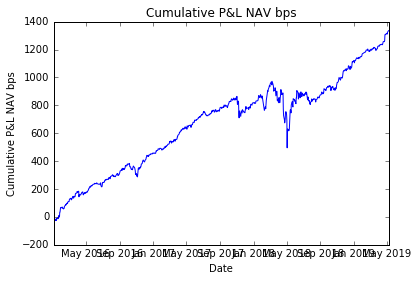

In [112]:
plt.plot(pnl_df['Date'], pnl_df['Cum_PnL_NAV_bps'])
plt.xlabel('Date')
plt.ylabel('Cumulative P&L NAV bps')
plt.title('Cumulative P&L NAV bps')

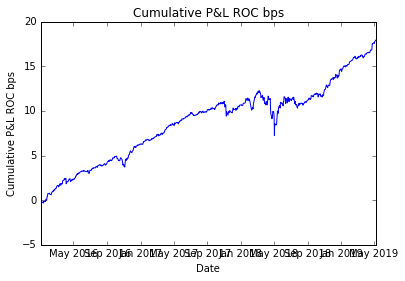

In [113]:
plt.plot(sleeve_df['Date'], sleeve_df['Cum_PnL_ROC_bps'])
plt.xlabel('Date')
plt.ylabel('Cumulative P&L ROC bps')
plt.title('Cumulative P&L ROC bps')